# Modelagem dos dados

In [94]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,precision_recall_curve, roc_curve,auc
import time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings
from collections import Counter
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import plot_roc_curve
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings("ignore")

In [95]:
#Desenho do gráfico de dispersão para visualização das amostras sintéticas criadas pelo algoritmo (SMOTE).
def drawGraphPoints(x,y, title=None):
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.scatter(x[y==1][:, 0], x[y==1][:, 1], label='class 1')
    plt.scatter(x[y==0][:, 0], x[y==0][:, 1], label='class 0')
    plt.legend()
    plt.grid(False)
    plt.show()  

#Gráfico da curva ROC - Comparação AUC entre os classificadores
def drawGraphAuc(classifier,title=None):
    plt.figure(figsize=(10,10))
    plt.title(title)

    for i in classifier.models:
        false_positive_rate, true_positive_rate, thresholds = roc_curve(classifier.Y_test, i['y_proba'])
        roc_auc = auc(false_positive_rate, true_positive_rate)
        plt.plot(false_positive_rate,true_positive_rate,label = 'AUC = %0.2f' % roc_auc + ' ' + i['name'])

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [96]:
#Criação de uma classe contendo diversos classificadores que serão utilizados nos testes
class Classifiers():
    def __init__(self,X_train=None,X_test=None,Y_train=None,Y_test=None):            
        if type(X_train) == type(None):
           
            #Leitura do arquivo
            df = pd.read_csv('Churn_Modelling.csv', delimiter=',')

            #Exclusão das colunas sem importância
            df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)
    
            #Label Encoder
            from sklearn.preprocessing import LabelEncoder
            LE = LabelEncoder()
            df['Geography'] = LE.fit_transform(df['Geography'])
            df['Gender'] = LE.fit_transform(df['Gender'])

            from sklearn.preprocessing import StandardScaler
            scaler=StandardScaler()
            df['Balance'] = scaler.fit_transform(df[['Balance']])
            df['EstimatedSalary'] = scaler.fit_transform(df[['EstimatedSalary']])
            df['Age'] = scaler.fit_transform(df[['Age']])

            #Divisão dos dados entre Teste e Treino
            X = df.drop('Exited',axis=1)
            Y = df['Exited']
            
            #Na separação dos dados entre treino e teste foi definido 20% dos registros para realização de teste.
            X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20,random_state=100)
            self.X_train = X_train
            self.X_test = X_test
            self.Y_train = Y_train
            self.Y_test = Y_test
        else:
            self.X_train = X_train
            self.X_test = X_test
            self.Y_train = Y_train
            self.Y_test = Y_test
    
    def getModels(self):
        '''
        Criação das instâncias dos classificadores com seus hiperparâmetros setados através da utilização do
        GridSearch - best param
        chamada para getBestParam 
        '''
        self.random_stateArg = 33
        listModels = []
        print('Total de linha e colunas: ',self.X_train.shape)
    
         #Logistic Regression
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(random_state=self.random_stateArg, C=0.08)
        listModels.append(model)
   

        #Bagging
        from sklearn.ensemble import BaggingClassifier
        dt = DecisionTreeClassifier()
        model = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                        max_leaf_nodes=15),
                  n_estimators=40, random_state=33)
        listModels.append(model)
        
        from xgboost import XGBClassifier
        model = XGBClassifier(n_jobs=-1,random_state=self.random_stateArg,eval_metric='logloss',n_estimators=90,
                                 max_depth=4,learning_rate=0.1)        
        listModels.append(model)
        
        from sklearn.ensemble import GradientBoostingClassifier
        model = GradientBoostingClassifier(random_state=self.random_stateArg)
        listModels.append(model)
        
        #ADA
        from sklearn.ensemble import AdaBoostClassifier
        model = AdaBoostClassifier(random_state=self.random_stateArg)
        listModels.append(model)
       
        #RandomForest
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(random_state=self.random_stateArg,max_depth=9,n_estimators=150 )
        listModels.append(model)
        
        #MultiLayerPerceptron
        from sklearn.neural_network import MLPClassifier
        model = MLPClassifier(random_state=self.random_stateArg)
        listModels.append(model)
        
        #KNN
        from sklearn.neighbors import KNeighborsClassifier
        accuracy = []
        for i in range(1,30):    
            kn = KNeighborsClassifier(n_neighbors=i)
            kn.fit(self.X_train,self.Y_train)
            predK = kn.predict(self.X_test)
            accuracy.append([accuracy_score(self.Y_test,predK),i])
        temp = accuracy[0]
        for m in accuracy:
            if temp[0] < m[0]:
                temp=m
        model = KNeighborsClassifier(n_neighbors=temp[1])
        listModels.append(model)     
       
        return listModels
    
    
    #hiperparâmetros - Utilização do GridSearch para encontrar a melhor parametrização dos modelos testados
    ''' Ex: 
    param_grid = {
    'base_estimator__max_depth' : [1, 2, 3, 4, 5],
    'max_samples' : [0.05, 0.1, 0.2, 0.5]
    }
    '''
    
    def getBestParam(self,model,grid):
        from sklearn.model_selection import StratifiedShuffleSplit
        
        '''
        O cv também aceita a atribuição de um objeto do StratifiedShuffleSplit, neste caso é necessário 
        a definição da quantidade de n_splits e o tamanho do dataset de testes.
        '''
        
        sss = StratifiedShuffleSplit(n_splits = 20, # 20 simulações.
                             test_size = 0.2,       # 20% do dataset será de testes.
                             random_state = self.random_stateArg)     # Permitir a reprodutibilidade.
        
        clf = GridSearchCV(model, param_grid = grid, cv = sss, verbose=True, n_jobs=-1, scoring = 'f1')
        '''
        scoring = f1: É a média harmônica entre precisão e revocação. Com essa informação podemos 
        dizer a performance do classificador com um indicador apenas.
        '''
        
        best_clf = clf.fit(self.X_train,self.Y_train)
        print('\nBest: ',best_clf.best_estimator_)    
    
    
    #Treinamento dos modelos e cálculo de alguns indicadores
    def buildModels(self):
        self.models = []
        listModels = self.getModels()
        
        for i in listModels:
            newModel = {}
            print('fit: ',i.__class__.__name__,' - ')
            start=time.time()
            i.fit(self.X_train,self.Y_train)
            stop=time.time()
            newModel['model'] = i
            newModel['name'] = i.__class__.__name__
            newModel['y_prob'] = i.predict(self.X_test)
            newModel['y_proba'] = i.predict_proba(self.X_test)[:,1]
            newModel['acc'] = accuracy_score(self.Y_test,newModel['y_prob'])
            newModel['mtx'] = confusion_matrix(self.Y_test, newModel['y_prob'])
            newModel['rel'] = classification_report(self.Y_test, newModel['y_prob'])
            newModel['runTime'] = "{:.4f}".format((stop-start))
            scores = cross_val_score(estimator = i, X = self.X_train, y = self.Y_train, cv = 10, n_jobs=-1)
            newModel['mean'] = np.mean(scores)
            newModel['std'] = np.std(scores)
        
            false_positive_rate, true_positive_rate, thresholds = roc_curve(self.Y_test, newModel['y_proba'])
            newModel['auc'] =  auc(false_positive_rate, true_positive_rate)

            self.models.append(newModel)
        
    def __str__(self):
        names = ''
        for i in self.models:
            names += i['name'] + ': ' + str(i['acc']) + ' - ' + str(i['runTime']) + '\n'
        return names

    '''
    Utilização do PCA com redução para 2 dimensões,com objetivo de realizar a plotagem do gráfico de dispersão para
    visualização do comportamento do SMOTE
    '''
    def pca(self):
        from sklearn.preprocessing import StandardScaler
        X_std = StandardScaler().fit_transform(self.X_train)

        from sklearn.decomposition import PCA 
        sklearn_pca = PCA(n_components=2)

        X_sklearn = sklearn_pca.fit_transform(X_std)
        return X_sklearn,self.Y_train
    
    #https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/
    def smote(self,X_train,Y_train):
        smt = SMOTE(random_state=2)
        X_smote, y_smote = smt.fit_resample(X_train, Y_train)
        return X_smote, y_smote
    
    def NearMiss(self,X_train,Y_train):
        undersample = NearMiss(version=1, n_neighbors=3)
        X_underS, y_underS = undersample.fit_resample(X_train, Y_train)
        return X_underS, y_underS

    def smoteenn(self,X_train,Y_train):
        from imblearn.combine import SMOTEENN
        smenn = SMOTEENN()
        X_smote, y_smote = smenn.fit_resample(X_train, Y_train)
        return X_smote, y_smote
    
    #conversão dos indicadores em formato de dicionário para dataframe para facilitar as comparações.
    def getIndicators(self, orderBy="times", ascendingArg=True):
        arrModel = []
        arrTime = []
        arrAcc = []
        arrAuc = []
        arrMean = []
        arrStd = []
        
        for i in self.models:
            arrModel.append(i['name'])
            arrTime.append(i['runTime'])
            arrAcc.append(i['acc'])
            arrAuc.append(i['auc'])
            arrMean.append(i['mean'])
            arrStd.append(i['std'])
            
        df2 = pd.DataFrame({'models':arrModel, 'times':arrTime,'acc':arrAcc,'auc':arrAuc,'mean':arrMean,'std':arrStd})
        return df2.sort_values(by=orderBy, ascending=ascendingArg).reset_index(drop=True)

In [97]:
#Build nos modelos 
basiClassifiers = Classifiers()
basiClassifiers.buildModels()

Total de linha e colunas:  (8000, 10)
fit:  LogisticRegression  - 
fit:  BaggingClassifier  - 
fit:  XGBClassifier  - 
fit:  GradientBoostingClassifier  - 
fit:  AdaBoostClassifier  - 
fit:  RandomForestClassifier  - 
fit:  MLPClassifier  - 
fit:  KNeighborsClassifier  - 


In [98]:
#Aplicando SMOTE
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=2)
X_smote, y_smote = smt.fit_resample(basiClassifiers.X_train,basiClassifiers.Y_train)
smoteClassifiers = Classifiers(X_smote,basiClassifiers.X_test,y_smote,basiClassifiers.Y_test)
smoteClassifiers.buildModels()

Total de linha e colunas:  (12750, 10)
fit:  LogisticRegression  - 
fit:  BaggingClassifier  - 
fit:  XGBClassifier  - 
fit:  GradientBoostingClassifier  - 
fit:  AdaBoostClassifier  - 
fit:  RandomForestClassifier  - 
fit:  MLPClassifier  - 
fit:  KNeighborsClassifier  - 


In [99]:
#Aplicando undersampling
from imblearn.under_sampling import NearMiss
undersample = NearMiss(version=1, n_neighbors=3)
X_underS, y_underS = undersample.fit_resample(basiClassifiers.X_train,basiClassifiers.Y_train)
underSamplingClassifiers = Classifiers(X_underS,basiClassifiers.X_test,y_underS,basiClassifiers.Y_test)
underSamplingClassifiers.buildModels()

Total de linha e colunas:  (3250, 10)
fit:  LogisticRegression  - 
fit:  BaggingClassifier  - 
fit:  XGBClassifier  - 
fit:  GradientBoostingClassifier  - 
fit:  AdaBoostClassifier  - 
fit:  RandomForestClassifier  - 
fit:  MLPClassifier  - 
fit:  KNeighborsClassifier  - 


# Análise da distribuição das classes aplicando PCA / SMOTE / NearMiss


Counter:  Counter({0: 6375, 1: 1625})


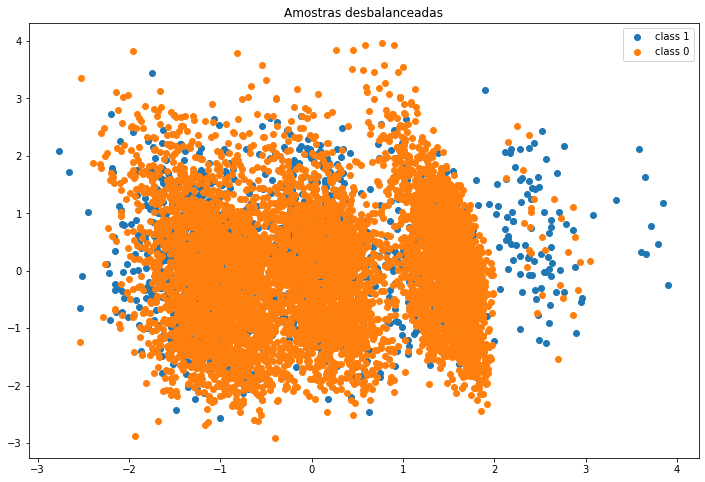

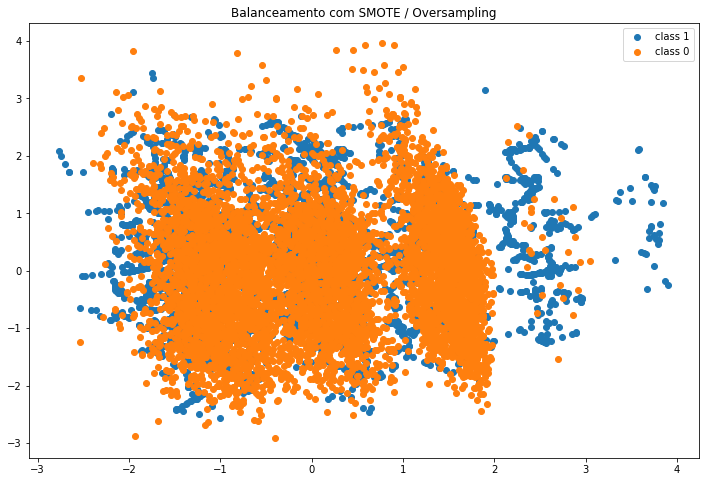


Counter:  Counter({1: 6375, 0: 6375})


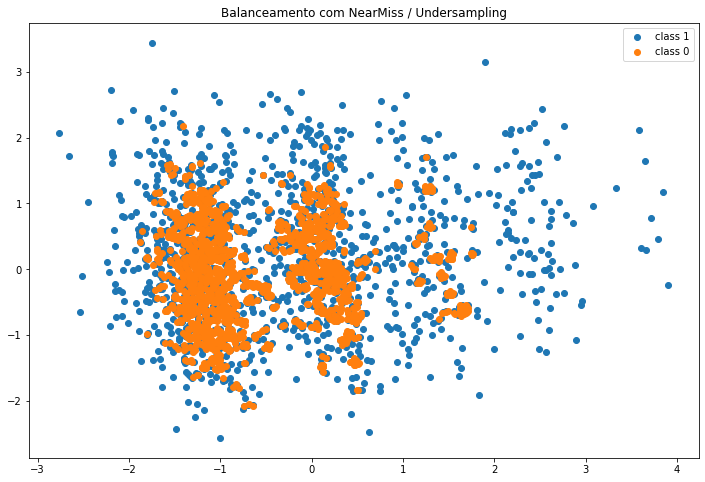


Counter:  Counter({0: 1625, 1: 1625})


In [100]:
#O propósito de utilizar o PCA foi somente para conseguirmos visualizar graficamente em 2 dimensões a distribuição da classe: Exited
x_pca, y = basiClassifiers.pca()
print('\nCounter: ',Counter(y))
drawGraphPoints(x_pca,y,'Amostras desbalanceadas')

#Com PCA E SMOTE
X_smote, y_smote = Classifiers().smote(x_pca,y)
drawGraphPoints(X_smote,y_smote, 'Balanceamento com SMOTE / Oversampling')

print('\nCounter: ',Counter(y_smote))

#Com PCA E NearMiss
X_underS, y_underS = Classifiers().NearMiss(x_pca,y)
drawGraphPoints(X_underS,y_underS,'Balanceamento com NearMiss / Undersampling')
print('\nCounter: ',Counter(y_underS))


    - Conforme os gráficos desenhados acima, podemos observar que o segundo (SMOTE) apresenta uma quantidade maior de 
    pontos da classe 1.
    
    - Alguns testes também foram realizados com o algoritmo ADASYN. Seria uma forma generalizada do algoritmo SMOTE.
    
    - Técnicas de balanceamento de undersampling também foram utilizadas através do algoritmo NearMiss: É um algoritmo
    que consiste em reduzir de forma aleatória os exemplos da classe majoritária, porém ele seleciona os exemplos 
    com base na distância. 

# Análise das métricas - técnicas de balanceamento

In [101]:
#Criando um dataframe com todas os indicadores
m = pd.merge(basiClassifiers.getIndicators(), smoteClassifiers.getIndicators(), how = 'inner', on = 'models', suffixes=('_basic', '_smote'),)
m = pd.merge(m, underSamplingClassifiers.getIndicators(), how = 'inner', on = 'models', suffixes=('', '_nearM'))
m

,models,times_basic,acc_basic,auc_basic,mean_basic,std_basic,times_smote,acc_smote,auc_smote,mean_smote,std_smote,times,acc,auc,mean,std
0,KNeighborsClassifier,0.0240,0.7980,0.627345,0.797000,0.004000,0.0410,0.7230,0.600161,0.873961,0.018226,0.0080,0.6755,0.566138,0.520615,0.040536
1,LogisticRegression,0.1060,0.8020,0.749298,0.808000,0.008825,0.1757,0.7255,0.737444,0.763137,0.051764,0.0710,0.6850,0.713589,0.686154,0.017132
2,AdaBoostClassifier,0.3090,0.8565,0.842731,0.854625,0.007887,0.5200,0.8040,0.831572,0.830118,0.044182,0.1410,0.6420,0.726407,0.764615,0.023524
3,XGBClassifier,0.4080,0.8595,0.858107,0.865750,0.005868,0.5920,0.8285,0.846830,0.855922,0.054209,0.2060,0.6915,0.763881,0.775385,0.021887
4,BaggingClassifier,0.4480,0.8485,0.827117,0.856875,0.010220,0.6875,0.7985,0.826100,0.806824,0.046220,0.2320,0.7135,0.777645,0.754769,0.018310
5,GradientBoostingClassifier,0.9550,0.8605,0.854374,0.865750,0.008518,1.7300,0.8315,0.846890,0.849569,0.048644,0.4700,0.7010,0.773564,0.770154,0.021007
6,RandomForestClassifier,1.1011,0.8525,0.850403,0.862750,0.006586,1.7166,0.8140,0.838623,0.847843,0.050904,0.5160,0.7260,0.770353,0.759385,0.018348
7,MLPClassifier,1.5766,0.7535,0.749327,0.798125,0.018752,2.4695,0.7240,0.739577,0.727922,0.059909,1.0568,0.6190,0.715040,0.652615,0.050173


# Comparação das amostras: Desbalanceada / SMOTE / NearMiss

In [102]:
auc_comp = m[['models', 'auc_basic','auc_smote','auc']]
auc_comp

,models,auc_basic,auc_smote,auc
0,KNeighborsClassifier,0.627345,0.600161,0.566138
1,LogisticRegression,0.749298,0.737444,0.713589
2,AdaBoostClassifier,0.842731,0.831572,0.726407
3,XGBClassifier,0.858107,0.846830,0.763881
4,BaggingClassifier,0.827117,0.826100,0.777645
5,GradientBoostingClassifier,0.854374,0.846890,0.773564
6,RandomForestClassifier,0.850403,0.838623,0.770353
7,MLPClassifier,0.749327,0.739577,0.715040


# Análise do Recall 

In [103]:
ind = 2
print(basiClassifiers.models[ind]['name'])
print(basiClassifiers.models[ind]['rel'])

XGBClassifier
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1588
           1       0.80      0.43      0.56       412

    accuracy                           0.86      2000
   macro avg       0.83      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000



In [104]:
print(smoteClassifiers.models[ind]['rel'])

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1588
           1       0.58      0.62      0.60       412

    accuracy                           0.83      2000
   macro avg       0.74      0.75      0.74      2000
weighted avg       0.83      0.83      0.83      2000



Comparando o valor do recall entre modelos apresentados, o valor da acurácia teve um pequena queda, mas tivemos um ganho no recall para a classe 1.

# Análise da matriz de confusão
    
    A matriz de confusão nos mostra o número exato de registros classificados por classe.

In [105]:
print(basiClassifiers.models[ind]['mtx'])

[[1543   45]
 [ 236  176]]


In [106]:
print(smoteClassifiers.models[ind]['mtx'])

[[1401  187]
 [ 156  256]]


# A melhor escolha do classificador considerando maior AUC

In [107]:
basiClassifiers.getIndicators("auc",False)

,models,times,acc,auc,mean,std
0,XGBClassifier,0.4080,0.8595,0.858107,0.865750,0.005868
1,GradientBoostingClassifier,0.9550,0.8605,0.854374,0.865750,0.008518
2,RandomForestClassifier,1.1011,0.8525,0.850403,0.862750,0.006586
3,AdaBoostClassifier,0.3090,0.8565,0.842731,0.854625,0.007887
4,BaggingClassifier,0.4480,0.8485,0.827117,0.856875,0.010220
5,MLPClassifier,1.5766,0.7535,0.749327,0.798125,0.018752
6,LogisticRegression,0.1060,0.8020,0.749298,0.808000,0.008825
7,KNeighborsClassifier,0.0240,0.7980,0.627345,0.797000,0.004000


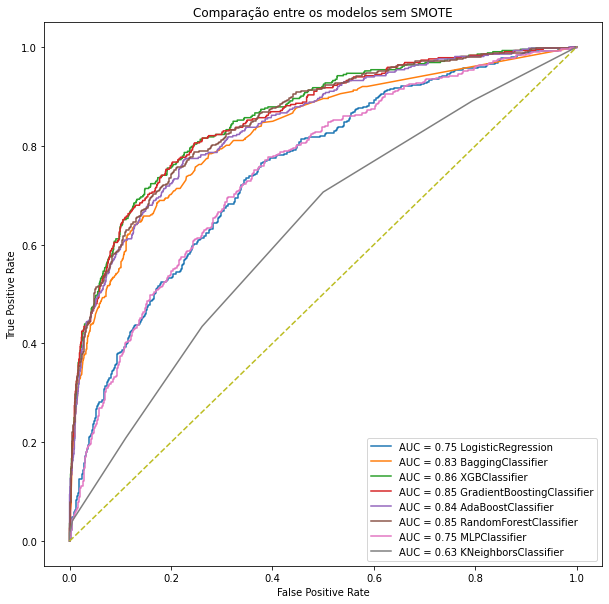

In [108]:
drawGraphAuc(basiClassifiers,'Comparação entre os modelos sem SMOTE')

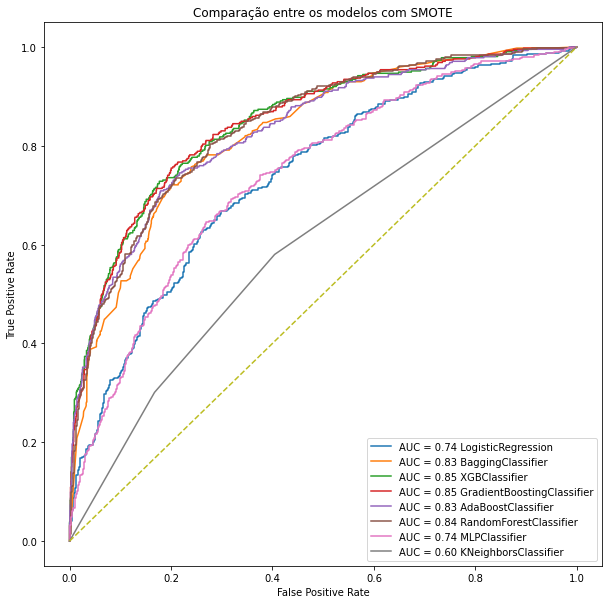

In [109]:
drawGraphAuc(smoteClassifiers,'Comparação entre os modelos com SMOTE')

# Utilização da biblioteca pycaret para efeito de comparação

    - PyCaret é uma biblioteca de aprendizado de máquina de código aberto Python projetada para facilitar a execução de   tarefas padrão em um projeto de aprendizado de máquina.
    

In [110]:
#from pycaret import classification
#df = pd.read_csv('Churn_Modelling.csv', delimiter=',')

#Exclusão das colunas sem importância
#df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

#classification_setup = classification.setup(data=df, target = 'Exited')


Segue abaixo um print de um dos relatórios gerados pela biblioteca

<img src="anexos/pycaret_compare_models.png">